# Loop over g values and return power spectra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from SchroPoissonSolver import fdmSimulation, Center
from PowerSpectrum import PowerSpectrum

def Gaussian(k, A, k0):
    return A*np.exp(-k**2/k0**2)
#     return A*np.exp(-k/k0)

def Maxwell(v , A, sigma,n):
    return A *v* np.exp(-0.5 * (v/sigma)**n)

rho0 = np.loadtxt("Simulation Runs//rho0_N400.csv", delimiter=",")

N = np.shape(rho0)[0]

psi_tilde_2 = 1e-3
G_N = 1e7
g_vals = np.linspace(0, 1e-1, 10)*G_N


dt = 1/N**2/np.pi  # timestep
T  = 0.06 #5000*dt #6000*dt# time at which simulation ends
Ns = 100 # number of time samples to save

# start = 375 # starting index for the fit, ignoring low k's
# end = 430 # ending index, ignoring high k's

start = 200
end = 285

power_spectra = []
Amps = []
cutoffs = []
lengths = []
errors = []
vs_rms = []
vs_peak = []
dv = []

i = 0

for g in g_vals:
    psi, delta, psiSlices = fdmSimulation(rho0 , psi_tilde_2, G_N, g, T, dt, Ns)
    np.save( "Simulation Runs//psiSlices"+str(N)+"g"+str(g/G_N) , psiSlices)
    np.save( "Simulation Runs//deltaRMS"+str(N)+"g"+str(g/G_N), delta)
    
    spectra = np.zeros((Ns , N-1))
    v_rms_temp = np.zeros((Ns))
    v_peak_temp = np.zeros((Ns))
    dv_temp = np.zeros((Ns))

    for j in range(Ns):
        k_modes, spectra[j, :] = PowerSpectrum(np.abs(psiSlices[j,:,:])**2)
        phase = np.angle(psiSlices[j,:,:])
        v_y, v_x = np.gradient(phase)
        v_mag = np.linalg.norm(np.gradient(phase), axis=0)

        hist, bins = np.histogram(v_mag, bins=int(N**1.1))
        vs_peak.append( bins[np.argmax(hist)] )
        
        
        v_mag2 = v_mag**2
        v_rms_temp[j] = np.sqrt(np.average(v_mag2))
        dv_temp[j] = np.std(v_mag)
        
#         cut = 100 # index up to which to perform p(v) curve-fit
        popt, pcov = curve_fit(Maxwell, bins[1:], hist[:], [1000, bins[np.argmax(hist)], 2])
        Dist = Maxwell(bins, popt[0], popt[1], popt[2])
        v_peak_temp[j] = bins[np.argmax(Dist)]
        

    power_spectra.append(np.average(spectra, axis=0)) 
    vs_rms.append(np.average(v_rms_temp))
    dv.append(np.average(dv_temp))
    vs_peak.append(np.average(v_peak_temp))
#     std = np.std(spectra, axis=0)
    popt, pcov = curve_fit(Gaussian, k_modes[start:end], power_spectra[i][start:end], [1e-4, 20])
    Amps.append(popt[0])
    cutoffs.append(popt[1])
    lengths.append(1/popt[1])
    errors.append(pcov[1][1])
    i += 1

/var/folders/sq/h1zpjmyn11j4ck1mhhfcmy0r0000gn/T/ipykernel_24335/1869554664.py:12: RuntimeWarning: invalid value encountered in power
  return A *v* np.exp(-0.5 * (v/sigma)**n)


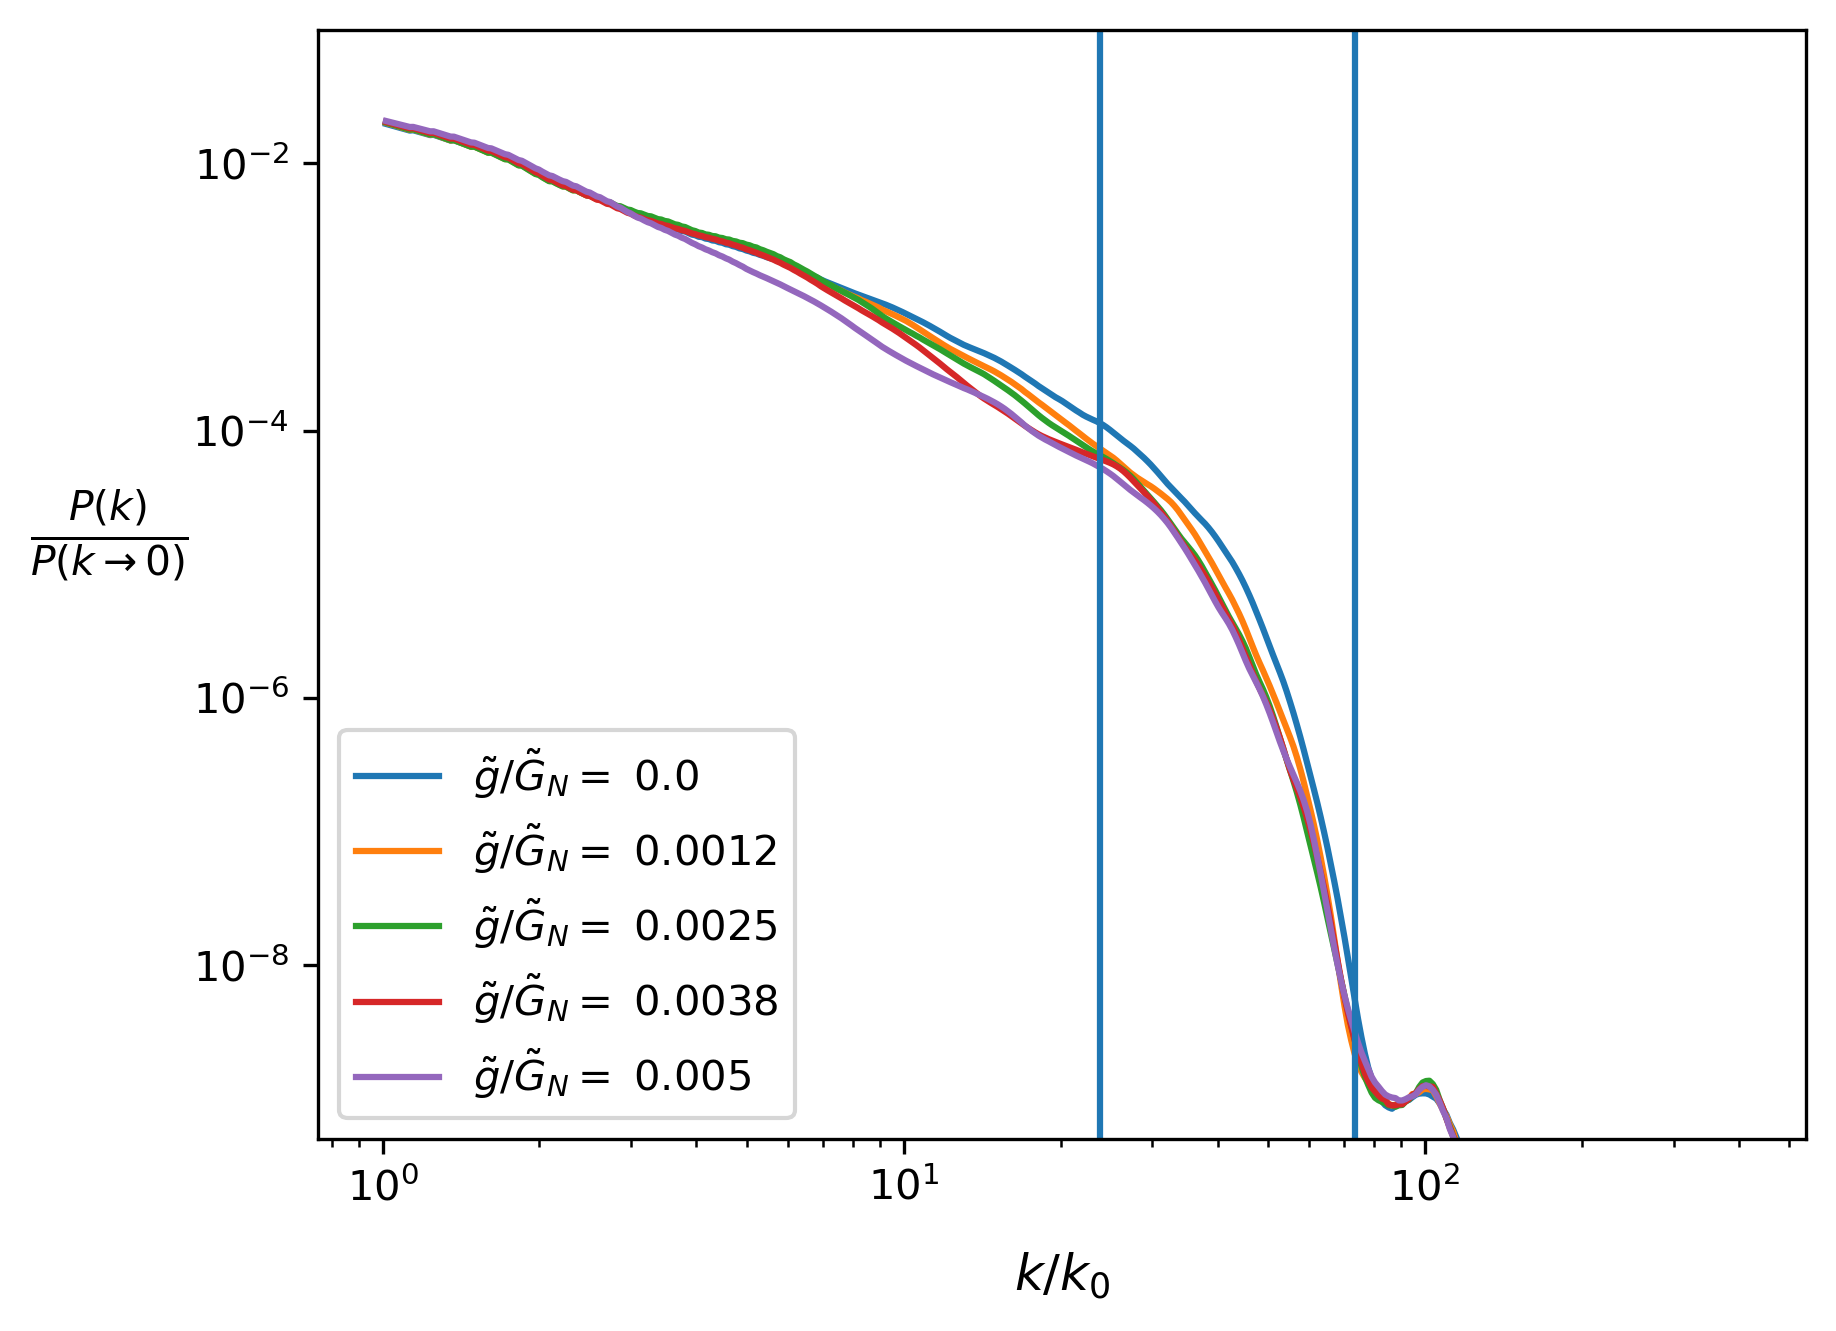

21.860105912287494

In [9]:
plt.figure(dpi = 300)
plt.xlabel(r"$k/k_{0}$", labelpad = 10, fontsize=12)
plt.ylabel(r"$\frac{P(k)}{P(k\rightarrow 0)}$", rotation = 0, labelpad = 20,fontsize=14 )
for i in range(0,np.shape(power_spectra)[0],1):
    plt.loglog(k_modes, power_spectra[i], label = r"$\tilde{g}/\tilde{G}_N=$ "+str(round(g_vals[i]/G_N, 4 )))
#     plt.loglog(k_modes, Gaussian(k_modes, Amps[i], cutoffs[i]), linestyle="--")


# plt.loglog(k_modes, power_spectra[0], label = r"$\tilde{g}/\tilde{G}_N=$ "+str(round(g_vals[0], 3 )/G_N),color="teal")
# # plt.loglog(k_modes/cutoffs[0], Gaussian(k_modes, Amps[0], cutoffs[0]),color="teal", linestyle=":")
# plt.loglog(k_modes, power_spectra[-1], label = r"$\tilde{g}/\tilde{G}_N=$ "+str(round(g_vals[-1], 3 )/G_N), color = "chocolate")
# # plt.loglog(k_modes/cutoffs[0], Gaussian(k_modes, Amps[-1], cutoffs[-1]), color="chocolate",linestyle=":")

# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.rcParams['axes.facecolor']='white'
plt.axvline(x=k_modes[start])
plt.axvline(x=k_modes[end])
plt.ylim(5e-10, 1e-1)
# plt.xlim(k_modes[start], k_modes[end])
plt.legend()
# plt.savefig("spectra"+str(N)+"G"+str(G_N)+".png",bbox_inches="tight")
plt.show()
cutoffs[0]

(5,)


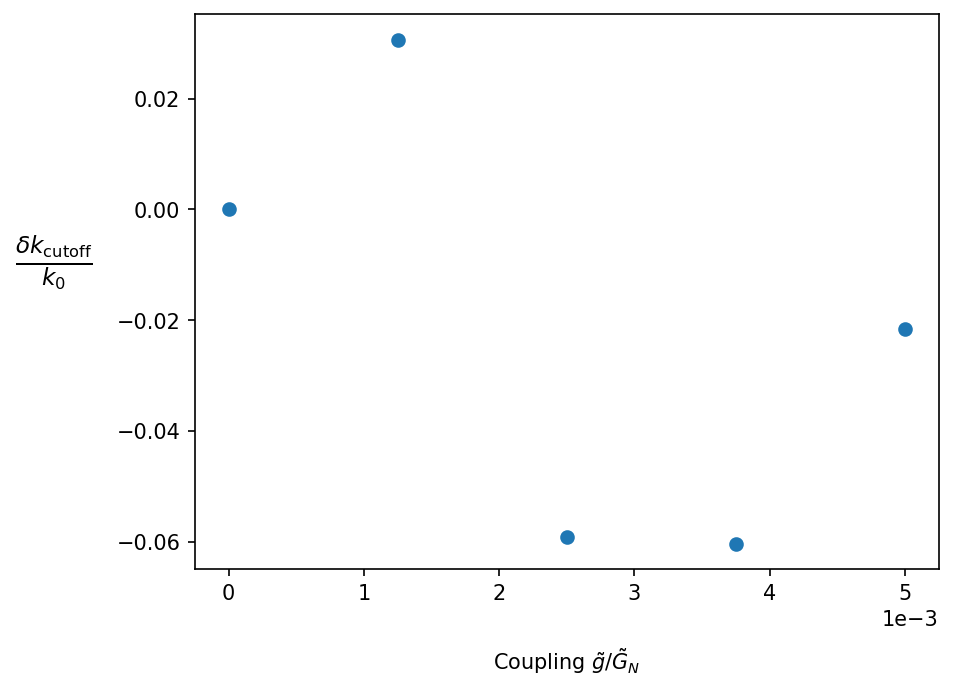

In [3]:
def F(x, a, b,c):
    return a*x**b+c

# popt, pcov = curve_fit(F, g_vals, (cutoffs-cutoffs[0])/cutoffs[0])

# print(popt)

g_new = np.linspace(0, g_vals[-1], 10)

print(np.shape(cutoffs))

plt.figure(dpi = 150)
# plt.errorbar(g_vals/G_N, (cutoffs-cutoffs[0]) / cutoffs[0] , errors /(cutoffs[0]), fmt="o" , capsize=2, markersize = 2, color = "k")
plt.scatter(g_vals/G_N, (cutoffs-cutoffs[0]) / cutoffs[0])# , errors /(cutoffs[0]), fmt="o" , capsize=2, markersize = 2, color = "k")
plt.xlabel(r"Coupling $\tilde{g}/\tilde{G}_N$", labelpad = 20)
plt.ylabel(r"$  \frac{\delta k_{\mathrm{cutoff}}}{k_0}$", rotation = 0, labelpad = 30,fontsize=16 )
# plt.plot(g_new/G_N , F(g_new, popt[0], popt[1], popt[2]))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.rcParams['axes.facecolor']='white'
# plt.savefig("cutoff-scaling"+str(N)+"GN"+str(G_N)+".png",bbox_inches="tight")
plt.show()

In [4]:
# np.savetxt("g_vals.csv", g_vals, delimiter=",")
# np.savetxt("power_spectra.csv", power_spectra, delimiter=",")

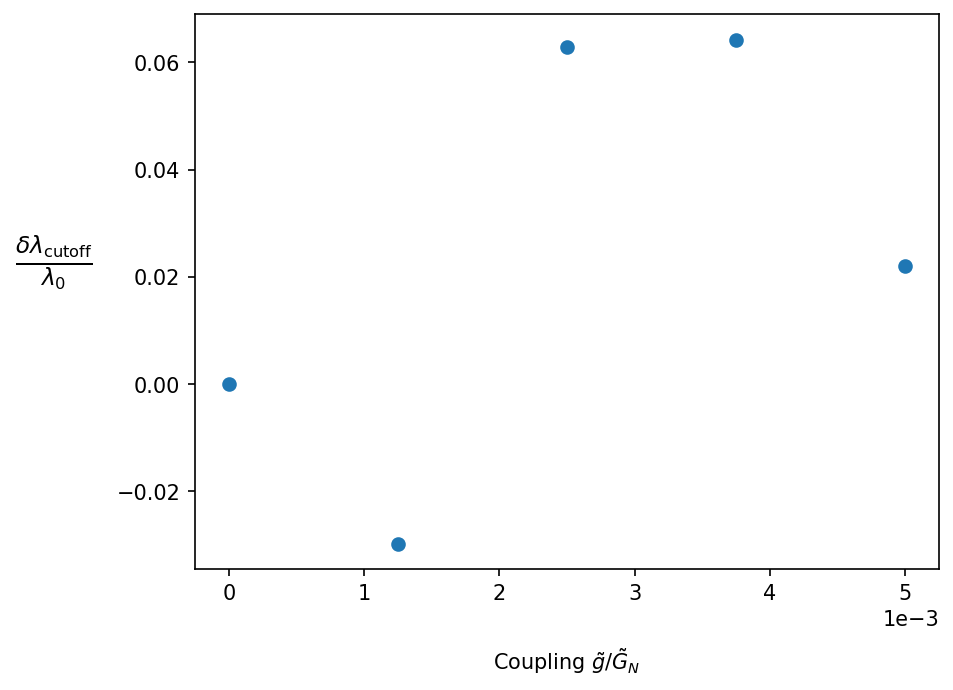

In [5]:
plt.figure(dpi = 150)
# plt.errorbar(g_vals/G_N, (lengths-lengths[0]) / lengths[0] , errors /np.asarray(cutoffs)**2 / lengths[0], fmt="o" , capsize=2, markersize = 2, color = "k")
plt.scatter(g_vals/G_N, (lengths-lengths[0]) /lengths[0])
plt.xlabel(r"Coupling $\tilde{g}/\tilde{G}_N$", labelpad = 20)
plt.ylabel(r"$\frac{\delta\lambda_{\mathrm{cutoff}}}{\lambda_0} $", rotation = 0, labelpad = 30,fontsize=16  )
# plt.plot(g_vals, .04/(g_vals+.2)**2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.rcParams['axes.facecolor']='white'
# plt.savefig("wavelength-scaling"+str(N)+"GN"+str(G_N)+".png",bbox_inches="tight")
plt.show()

# Now look at velocity distributions

In [6]:
# popt, pcov = curve_fit(F, g_vals, (vs_rms-vs_rms[0]) /vs_rms[0])

# print(popt)

# plt.figure(dpi = 150)
# # plt.errorbar(g_vals, lengths / np.average(lengths) , errors /(lengths)**2, fmt="o" , capsize=2, markersize = 2, color = "k")
# plt.scatter(g_vals/G_N, (vs_rms-vs_rms[0]) /vs_rms[0])
# plt.xlabel(r"Coupling $\tilde{g}/\tilde{G}_N$", labelpad = 20)
# plt.ylabel(r"$\frac{ \delta v_{\mathrm{rms}}}{v_{\mathrm{rms},0}} $", rotation = 0, labelpad = 30,fontsize=16  )
# # plt.plot(g_new/G_N, F(g_new, popt[0], popt[1],popt[2]))
# # plt.plot(g_vals, .04/(g_vals+.2)**2)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.rcParams['axes.facecolor']='white'
# # plt.savefig("vrms-scaling"+str(N)+"GN"+str(G_N)+".png",bbox_inches="tight")
# plt.show()

[1.84244039e-04 2.13872553e+01]


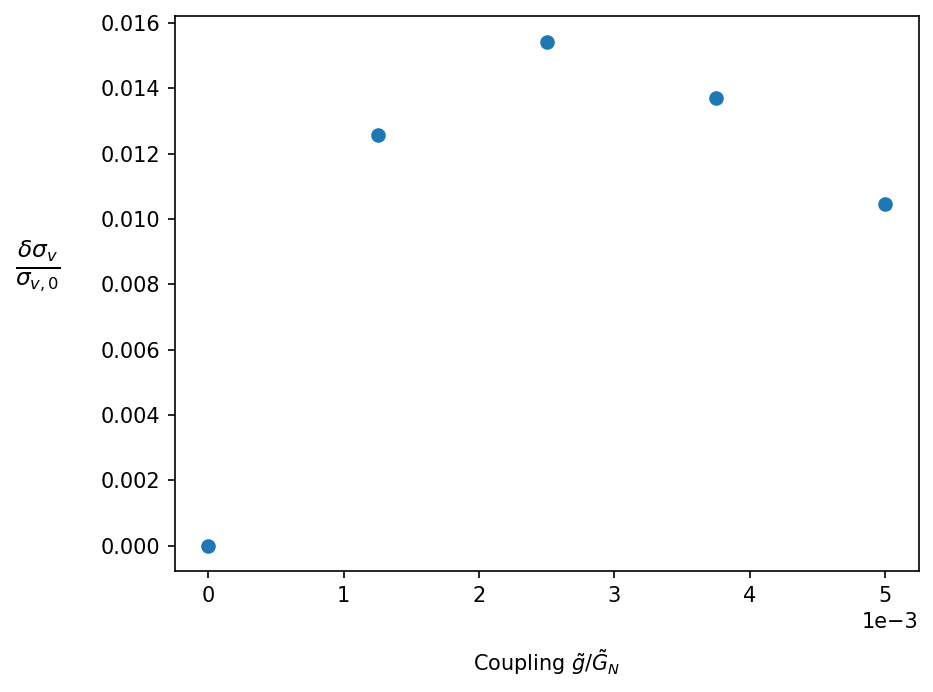

In [7]:
# popt, pcov = curve_fit(F, g_vals, (vs_peak-vs_peak[0]) /vs_peak[0])

print(popt)

plt.figure(dpi = 150)
# plt.errorbar(g_vals, lengths / np.average(lengths) , errors /(lengths)**2, fmt="o" , capsize=2, markersize = 2, color = "k")
plt.scatter(g_vals[0:]/G_N, (dv-dv[0]) /dv[0])
plt.xlabel(r"Coupling $\tilde{g}/\tilde{G}_N$", labelpad = 20)
plt.ylabel(r"$\frac{ \delta \sigma_v}{\sigma_{v,0}} $", rotation = 0, labelpad = 30,fontsize=16  )
# plt.plot(g_new, F(g_new, popt[0], popt[1],popt[2]))
# plt.plot(g_vals, .04/(g_vals+.2)**2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.rcParams['axes.facecolor']='white'
plt.show()